第１４章
畳み込みニューラルネットワークを使った深層コンピュータビジョン　（スライド１）

https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb

画像処理でよく使われる畳み込みニューラルネットワークとは　
https://kenyu-life.com/2019/03/07/convolutional_neural_network/　
（スライド２）畳み込み層

CNNとは、畳み込み層とプーリング層、全結合層をもつNN

「画像の深層学習」と言えばCNNというくらいメジャーな手法である。CNNはConvolutional Neural Networkの頭文字を取ったもので、ニューラルネットワークに「畳み込み」という操作を導入したものである。

#畳み込み層
　入力された画像に複数のフィルタで処理する。フィルタ処理の結果、入力画像は画像の特徴を表す複数の画像へ変換

#プーリング層
　画像の特徴が損なわれないように,画像サイズが縮小される

#全結合層

#入→畳→プ→畳→プ→全→全→出→（教）


#畳とプ　は、　画像の特徴を抽出する役割

Set up

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

In [5]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs(このノートブックの出力を実行中も安定させるために)
np.random.seed(42) #シード値 疑似乱数を作る時に使う、元となる数字42
tf.random.set_seed(42)

# To plot pretty figures きれいな図形を描くため
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures　写真を保存する場所
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
#グレースケールおよびRGB画像をプロットするためのユーティリティ関数の設定です。
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")#imshowは、画像の操作　　グレーにする関数
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")#imshowは、画像の操作　RGB画像にする関数
    plt.axis("off")

中国と花の写真を使用して実装

畳み込み層のゼロパディング
https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html

（スライド３）ゼロパディングとストライドとは
（スライド４）フィルタ
（スライド５）特徴量マップ

フィルタの色々　（縦線の強調、横線の強調）
https://www.mitani-visual.jp/mivlog/imageprocessing/edgefilter-summary.php

Metal device set to: Apple M2

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



2022-10-23 17:31:25.995710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-23 17:31:25.995792: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


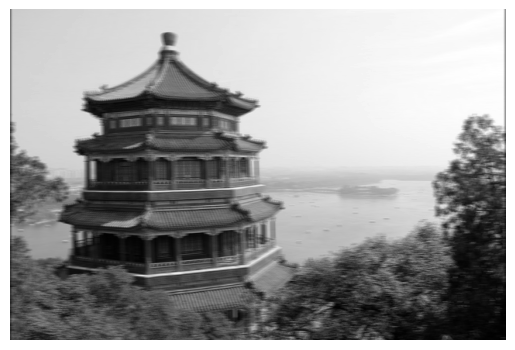

In [7]:
#TensorFlowとKerasによる実装　
import numpy as np
from sklearn.datasets import load_sample_image

# サンプル画像のロード
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
#個々のカラーチャネルの明度は1バイト（0から255まで）で表されるので、255で割れば0から1までの浮動小数点数が得られる。

images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# ２個のフィルタの作成　次に、7×7のフィルタを作る（1つは中央に縦の白線があるもので、もう1つは中央に横の白線があるもの。）
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 縦線
filters[3, :, :, 1] = 1  # 横線

#TensoroFlow の低水準深層学習API に含まれるtf.nn.conv2d() 関数を両画像に適用する。この例では、ゼロパディング（padding="SAME"）とストライド1 を使っている。
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

#tf.nn.conv2d() の説明　imagesは入力ミニバッチ（4次元テンソル）。filtersは適用するフィルタセット（4次元テンソル）。
#stridesは1に設定　paddingはSAMEかVALID     SAMEは、畳み込み層は必要に応じてゼロパディングを使う、　VALIDは、畳み込み層は０パディングを使わない。

#第１画像の第２特徴量マップをプロット
plt.imshow(outputs[0, :, :, 1], cmap="gray") 
plt.axis("off") # Not shown in the book
plt.show()

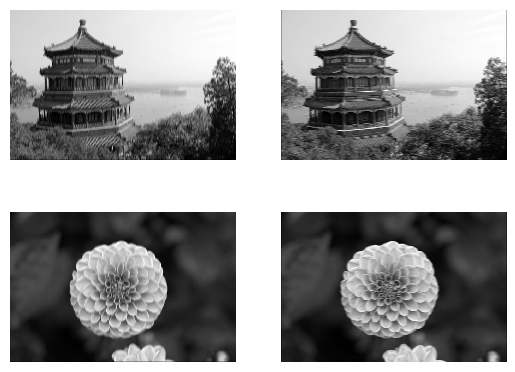

In [8]:
#元の画像と第１画像の第２特徴量マップを並べる
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1) #複数のグラフを書く
        plot_image(outputs[image_index, :, :, feature_map_index]) #グレースケールをプロットする関数
plt.show()

In [9]:
#Python, Pillowで画像の一部をトリミング（切り出し/切り抜き）する関数の設定
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


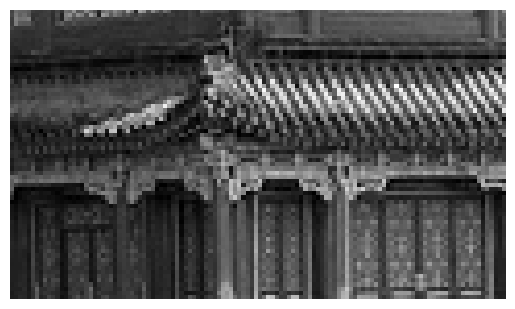

Saving figure china_vertical


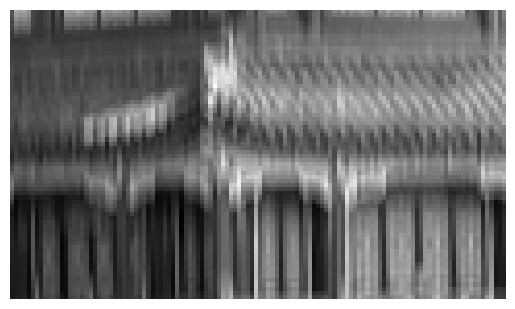

Saving figure china_horizontal


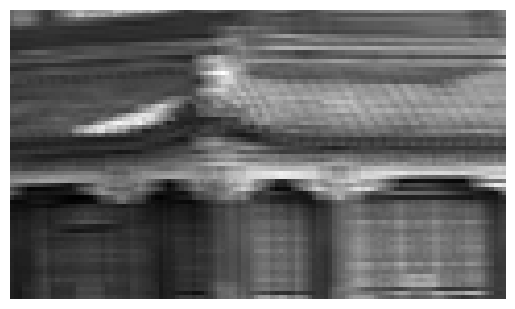

In [10]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

#トリミングした　オリジナル画像、縦線の特徴画像、横線の特徴画像を示す

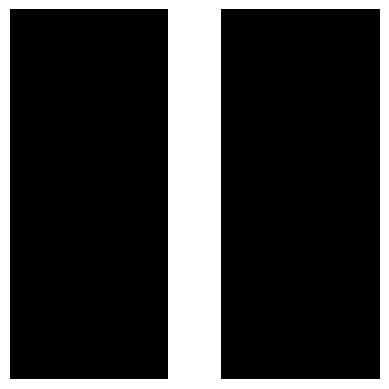

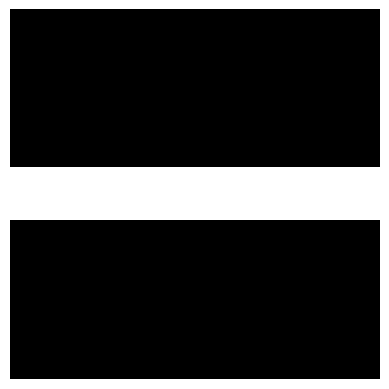

In [11]:
#縦線のフィルター、横線のフィルター

plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

畳み込み層　Convolutional Layer　
keras.lays.Conv2D()を使って、2Dの畳み込みレイヤーを作ってみる。実際のCNNでは、手作業で変数を作らず、keras.layers.Conv2D層を使う。

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

#keras.layers.Conv2D層の説明
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)
#7*７の２個のフィルタを持ち、縦横ともストライドは１でsameパディングを使い、出力にReLU活性化関数をかけるConv2D層を作る



例では手作業でフィルタを作ったが、実際のCNNでは、通常訓練可能変数としてフィルタを定義し、ニューラルネットがもっともうまく機能するフィルタを学習できるようにする。この場合、手作業で変数を作らず、keras.layers.Conv2D層を使う

このコードは、それぞれ７ × ７ の２ 個のフィルタを持ち、縦横ともストライドは1 で"same"パディングを使い†7、出力にReLU活性化関数をかけるConv2D層を作る。

畳み込み層には、かなりの数のハイパーパラメータがある。フィルタの数、その高さと幅、ストライド、パディングタイプを選択しなければならない。いつものように交差検証を使えば、適切なハイパーパラメータ値を見つけられるが、時間がかかる。


In [13]:
#このレイヤーを呼び出し、2枚のテスト画像(images = np.array([china, flower]))を渡すことにしましょう。
conv_outputs = conv(images) 
conv_outputs.shape 


TensorShape([2, 427, 640, 2])

TensorShape([2,427,640,2])の説明


#テンソルのShapeとは、各Dimension(=axis)がいくつの要素(Element)で構成さらたかを表す情報です。https://qiita.com/kotai2003/items/b977a28660bba2a07dc7



The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since padding="SAME" and strides=1, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

出力は4次元のテンソルである。次元は、バッチサイズ、高さ、幅、チャンネルである。最初の次元（バッチサイズ）は、入力画像が2枚なので2である。次の2次元は出力特徴マップの高さと幅で、padding="SAME"、strides=1なので、出力特徴マップは入力画像と同じ高さと幅（この場合、427×640）である。最後に、この畳み込み層は2つのフィルタを持っているので、最後の次元は2です：入力画像1枚につき2つの出力特徴マップが存在します。


Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:
フィルタはランダムに初期化されるため、最初はランダムなパターンが検出されます。それぞれの画像について、2つの出力特徴マップを見てみましょう。

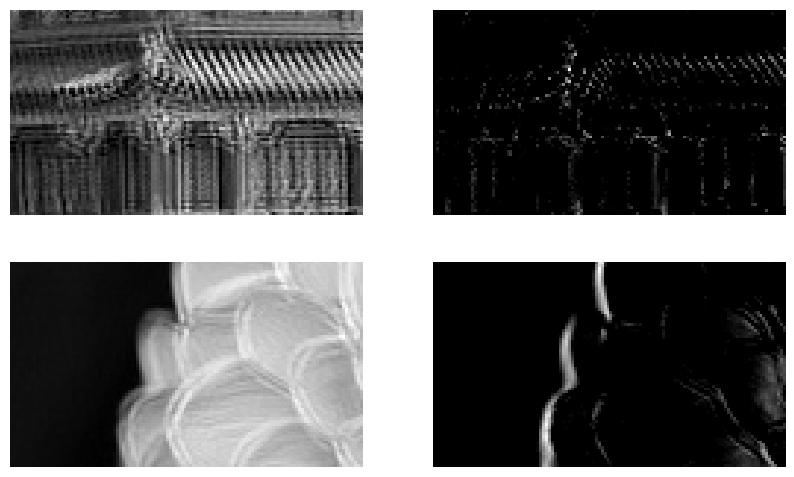

In [11]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Although the filters were initialized randomly, the second filter happens to act like an edge detector. Randomly initialized filters often act this way, which is quite fortunate since detecting edges is quite useful in image processing.

If we want, we can set the filters to be the ones we manually defined earlier, and set the biases to zeros (in real life we will almost never need to set filters or biases manually, as the convolutional layer will just learn the appropriate filters and biases during training):

フィルターはランダムに初期化されているが、2番目のフィルターは偶然にもエッジ検出器のように動作する。ランダムに初期化されたフィルターはしばしばこのように動作しますが、エッジの検出は画像処理において非常に有用であるため、これは非常に幸運なことです。

もし必要なら、先ほど手動で定義したフィルタを設定し、バイアスをゼロに設定することもできます（実際のところ、畳み込み層は学習中に適切なフィルタとバイアスを学習するだけなので、フィルタやバイアスを手動で設定する必要はほとんどないでしょう）。

In [14]:
conv.set_weights([filters, np.zeros(2)])#keras.layers.Conv2D層を使う　＃Numpy型配列リストからモデルの重みをセットする 

Now let's call this layer again on the same two images, and let's check that the output feature maps do highlight vertical lines and horizontal lines, respectively (as earlier):
では、同じ2つの画像にこのレイヤーを再度呼び出し、出力された特徴マップがそれぞれ縦線と横線を強調していることを確認してみましょう（先ほどと同様です）。

In [15]:
conv_outputs = conv(images)#keras.layers.Conv2D層を使う
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

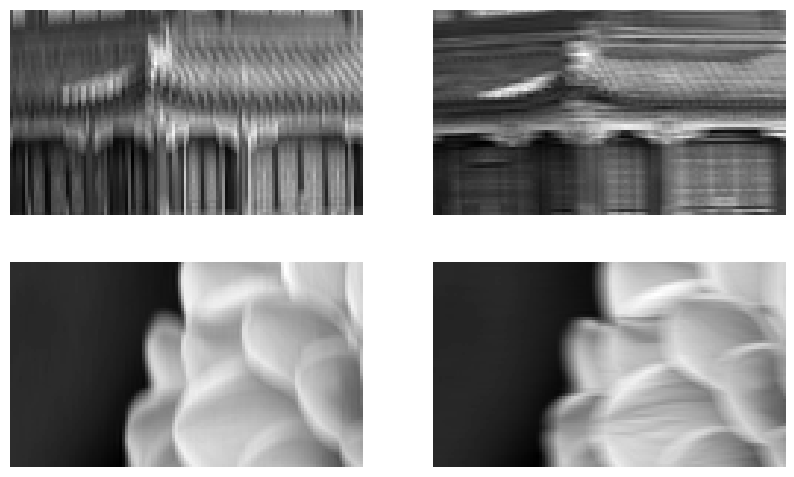

In [16]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

VALID vs SAME padding
（スライド６）

KerasのConv2Dを使う時にpaddingという引数があり、'valid'と'same'が選択できるのですが、これが何なのか

In [15]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):#特徴量マップ関数の設定
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1


In [16]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [17]:
def manual_same_padding(images, kernel_size, strides=1):#手動で manual_same_padding() 関数の設定
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using "SAME" padding is equivalent to padding manually using manual_same_padding() then using "VALID" padding (confusingly, "VALID" padding means no padding at all):

SAME "パディングを使用することは、手動で manual_same_padding() を使用してパディングした後に "VALID"パディングを使用することと同じ
（紛らわしいことに、"VALID" パディングとは全くパディングを行わないことを意味します）。

In [18]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")#VALIDと”SAME”の比較
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created　　　　　conv_same のウェイトが作成されるように build() を呼び出す必要がある．
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same　　　　conv_valid から conv_same に重みをコピーする．
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy()) #array同士を比較して一致するかassertでチェックする

メモリ要件（スライド７）